In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_8DLorenz.recursive_Markovian_PostMeanScore_8DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [3]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


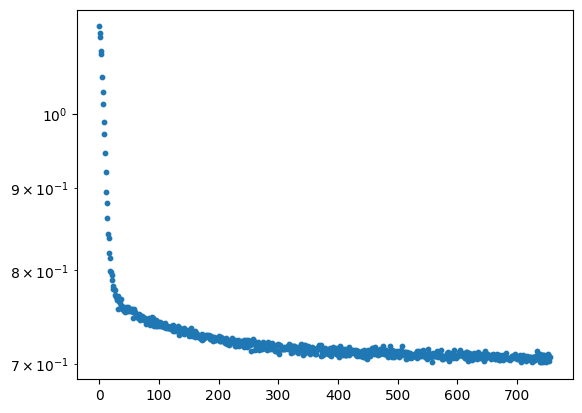

755

In [4]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

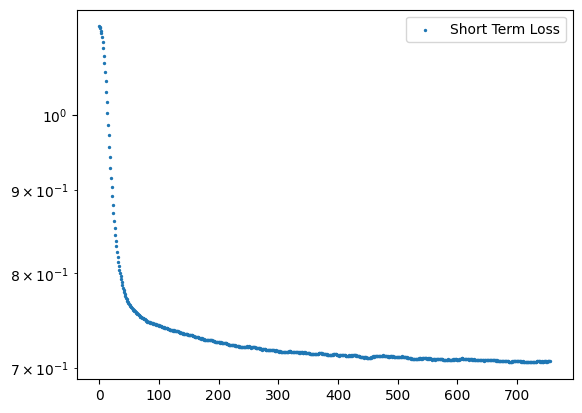

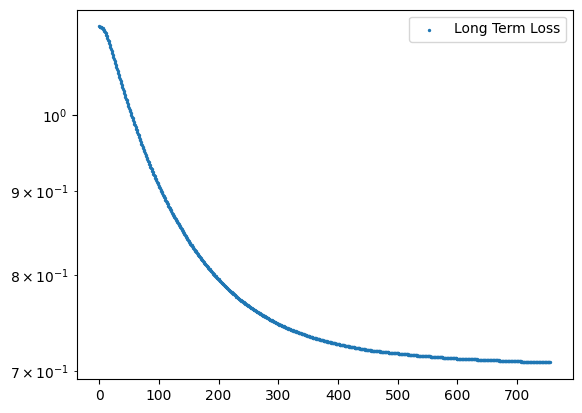

In [5]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

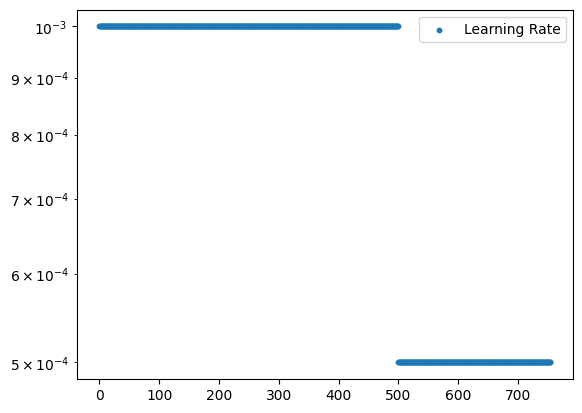

0


In [6]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(end-start+1)

In [7]:
def get_drift_files(config):
    ts_type = f"ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_".replace(".", "")
    include =  (f"_{1}NDT_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
    root_score_dir = root_dir + f"ExperimentResults/TSPM_Markovian/8DLnz/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "MLP" in file and ts_type in file and include in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_score_dir+file)
            elif "DriftTrack" in file and "global" in file:
                driftoostrack_local_files.append(root_score_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [8]:
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config)
len(Nepochs_track)

411

In [9]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_38585/4063213029.py:11: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_38585/4063213029.py:12: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


{1: 14.045576855253277,
 2: 12.205326791126362,
 4: 10.761753470960373,
 6: 5.519415972989408,
 8: 4.945840558524062,
 10: 5.738504006651262,
 12: 5.175111364466246,
 14: 5.218308609581793,
 16: 6.501422450824315,
 18: 6.171749346011614,
 20: 5.832501212324218,
 22: 5.202053134608921,
 24: 5.850602643664132,
 26: 5.01470320975903,
 28: 5.9609034990582215,
 30: 5.184932422738932,
 32: 5.18413141673637,
 34: 6.234552337287896,
 36: 5.91226275785131,
 38: 5.280236332861752,
 40: 5.2920535058216105,
 42: 5.3049844980293175,
 44: 5.231302163950139,
 46: 5.20238668711915,
 48: 5.323388801105787,
 50: 5.5224039510704035,
 52: 5.585252779547021,
 54: 5.232963469415386,
 56: 5.079223227312293,
 58: 6.321034693901918,
 60: 5.56293196896113,
 62: 5.268605892805133,
 64: 6.089127136879656,
 66: 5.219524307483745,
 68: 5.439205624695553,
 70: 5.408977821066875,
 72: 5.131094655401575,
 74: 5.492184052310979,
 76: 5.0250172849862755,
 78: 5.32084763686559,
 80: 5.339609393995275,
 82: 5.491262333703

In [10]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])

In [11]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(10, 5000))
print(common_epochs, Nepochs_track)
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
print(np.array(list(drift_track_rmses.values())).shape, track_idx)
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

[ 10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44
  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80
  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110 112 114 116
 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152
 154 156 158 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188
 190 192 194 196 198 200 202 204 206 208 210 212 214 216 218 220 222 224
 226 228 230 232 234 236 238 240 242 244 246 248 250 252 254 256 258 260
 262 264 266 268 270 272 274 276 278 280 282 284 286 288 290 292 294 296
 298 300 302 304 306 308 310 312 314 316 318 320 322 324 326 328 330 332
 334 336 338 340 342 344 346 348 350 352 354 356 358 360 362 364 366 368
 370 372 374 376 378 380 382 384 386 388 390 392 394 396 398 400 402 404
 406 408 410 412 414 416 418 420 422 424 426 428 430 432 434 436 438 440
 442 444 446 448 450 452 454 456 458 460 462 464 466 468 470 472 474 476
 478 480 482 484 486 488 490 492 494 496 498 500 50

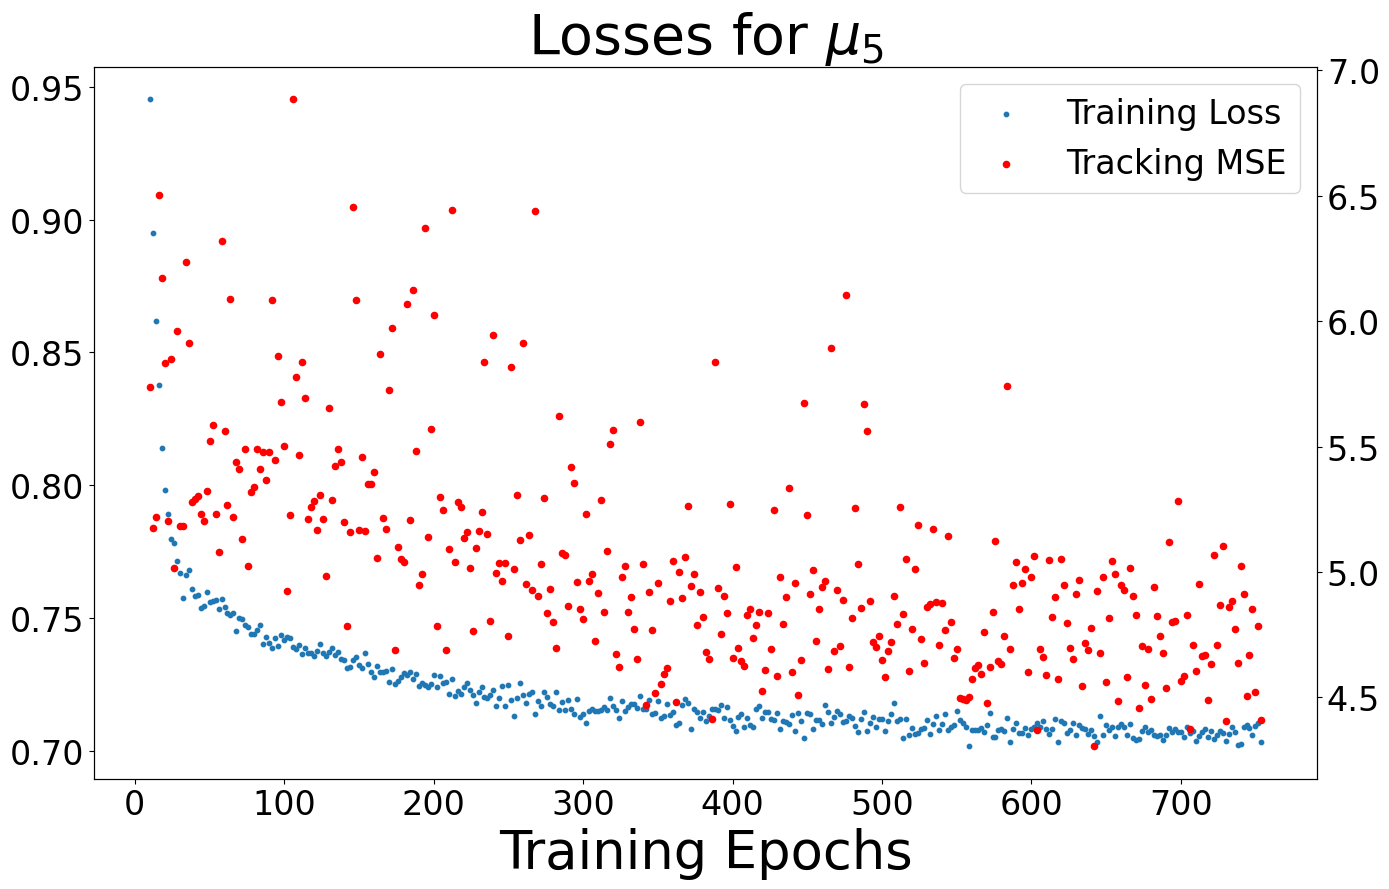

In [12]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for $\mu_{5}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/TSPM_Markovian/8DLnz/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_{config.forcing_const}FConst_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_38585/1981217831.py:16: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_38585/1981217831.py:17: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


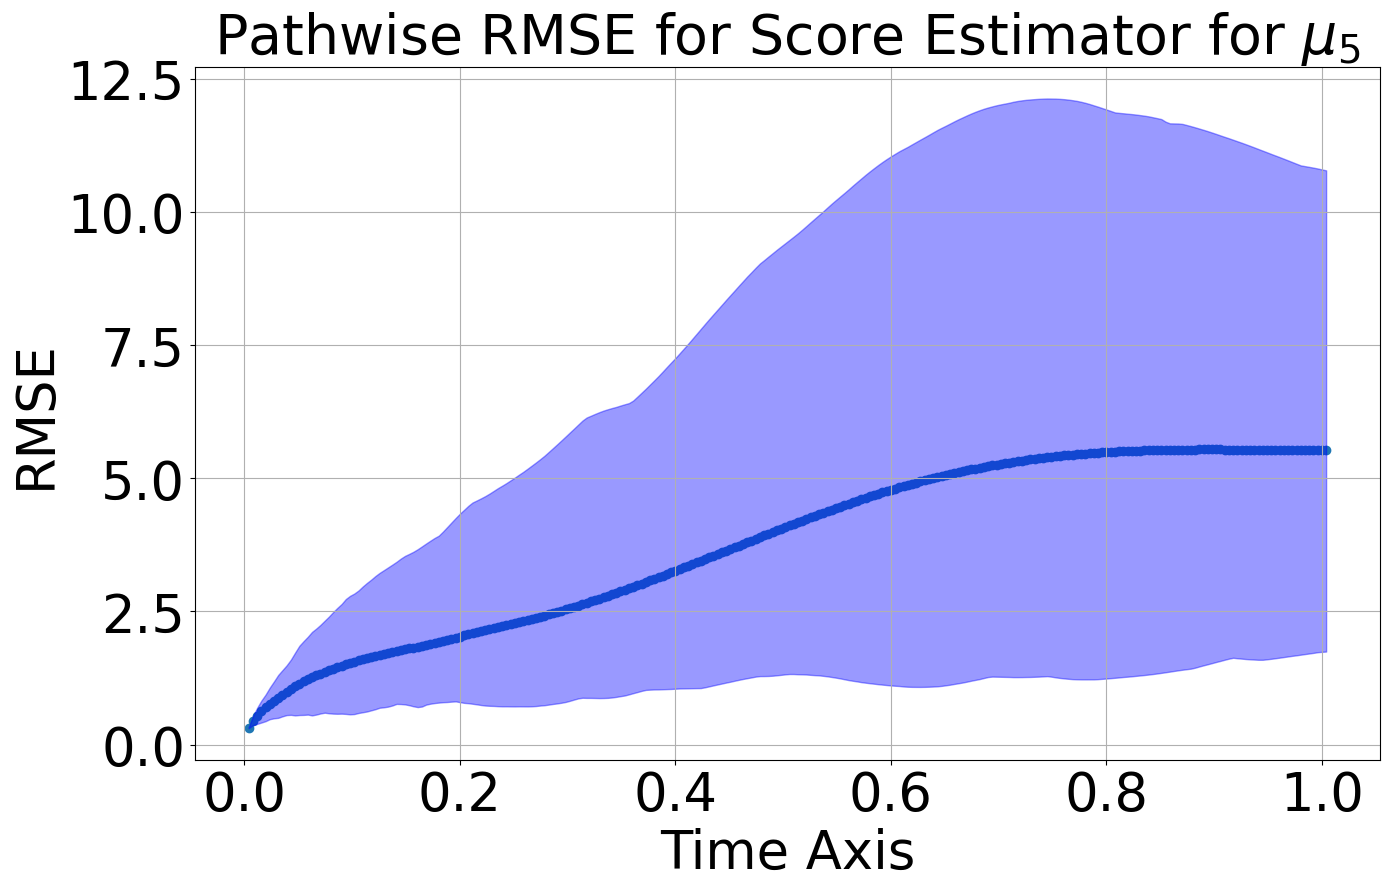

Final time cumulative MSE local-time error 5.5224039510704035 with final IQR (1.745482629531304, 10.778630954665688) at Nepoch 50 for 0.75FConst



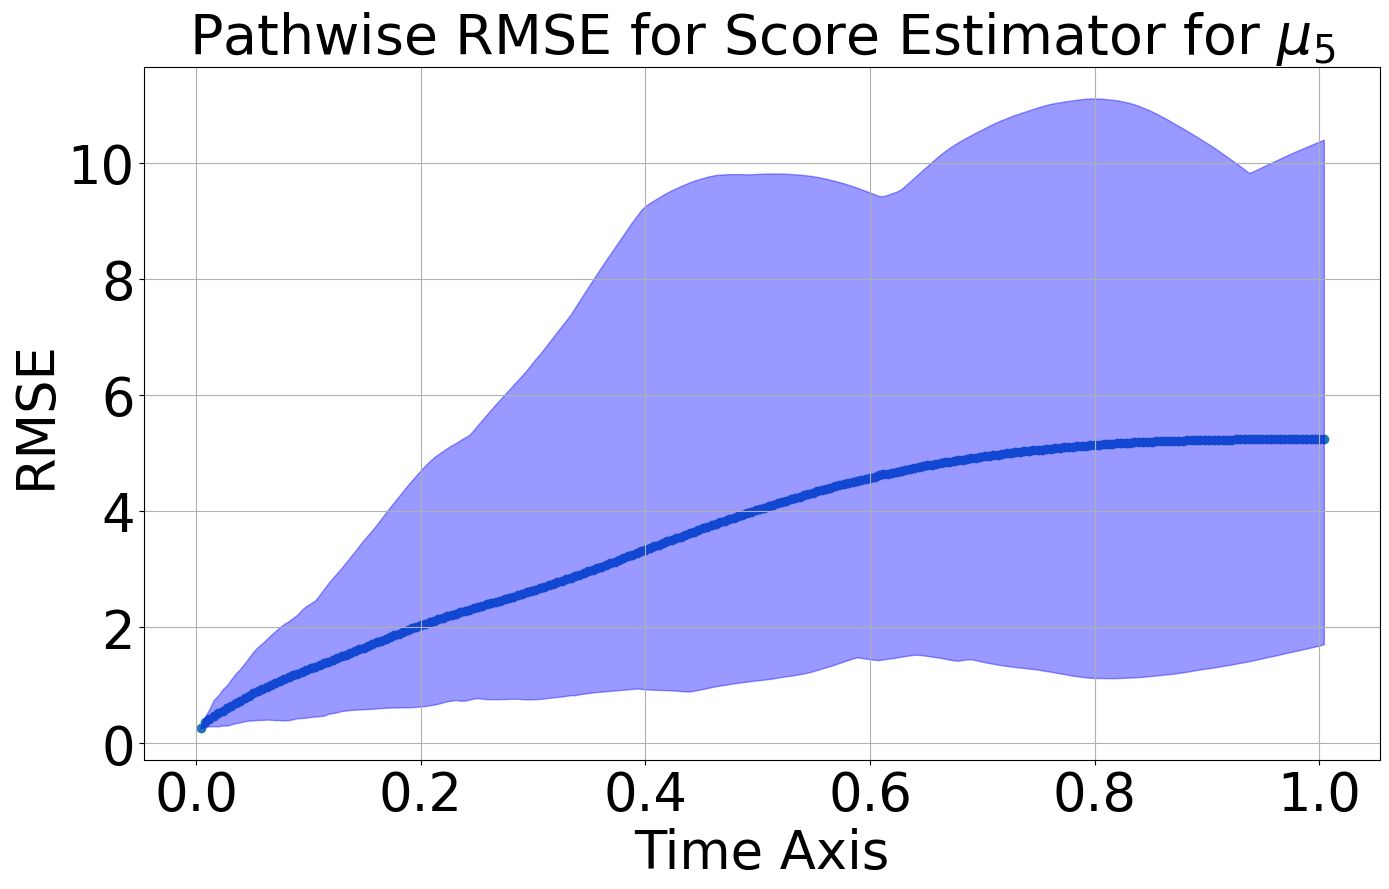

Final time cumulative MSE local-time error 5.232963469415386 with final IQR (1.7032584961989443, 10.391978673485003) at Nepoch 54 for 0.75FConst



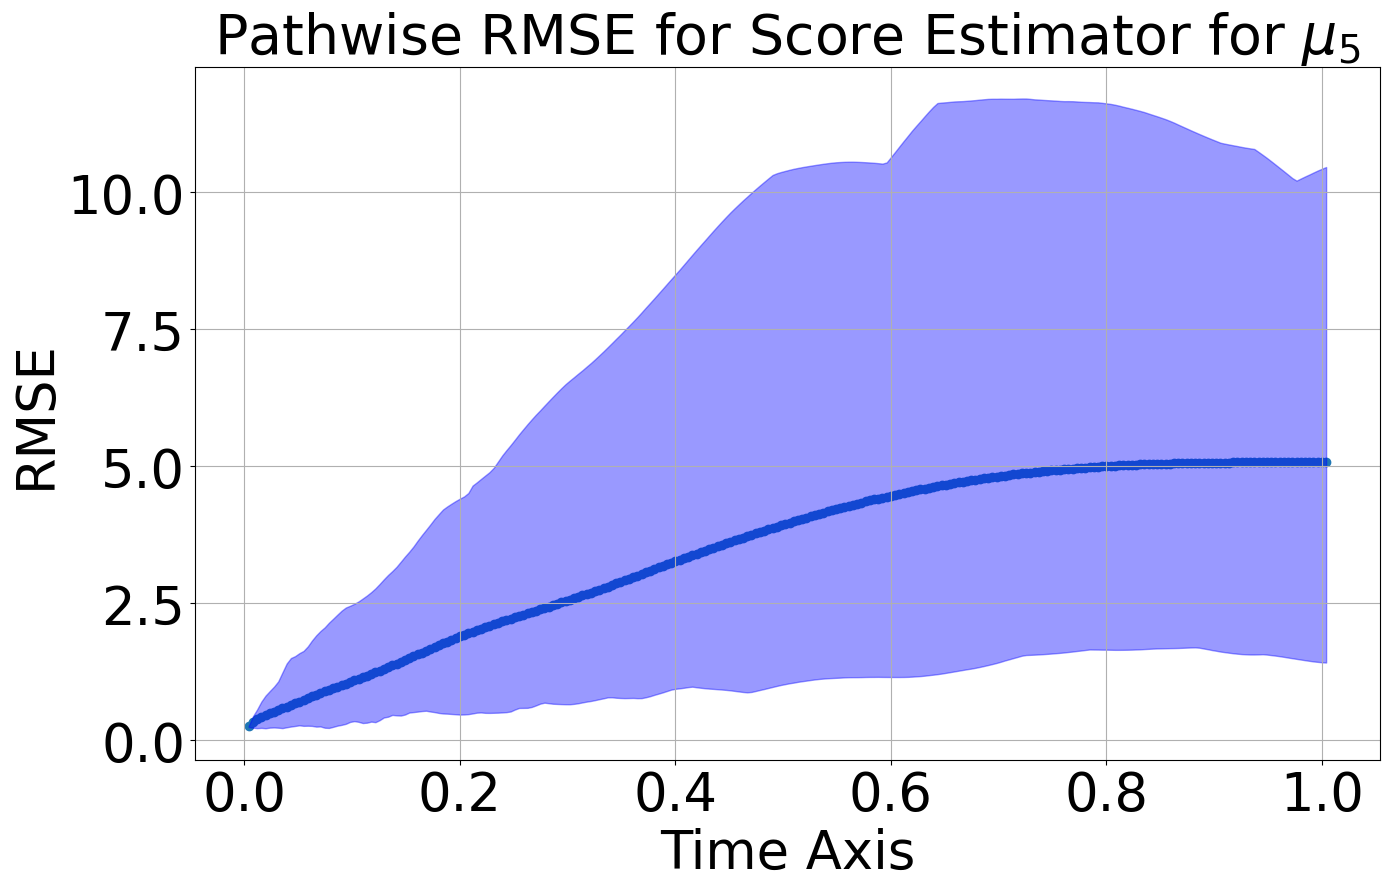

Final time cumulative MSE local-time error 5.079223227312293 with final IQR (1.416581509860278, 10.461017025705264) at Nepoch 56 for 0.75FConst



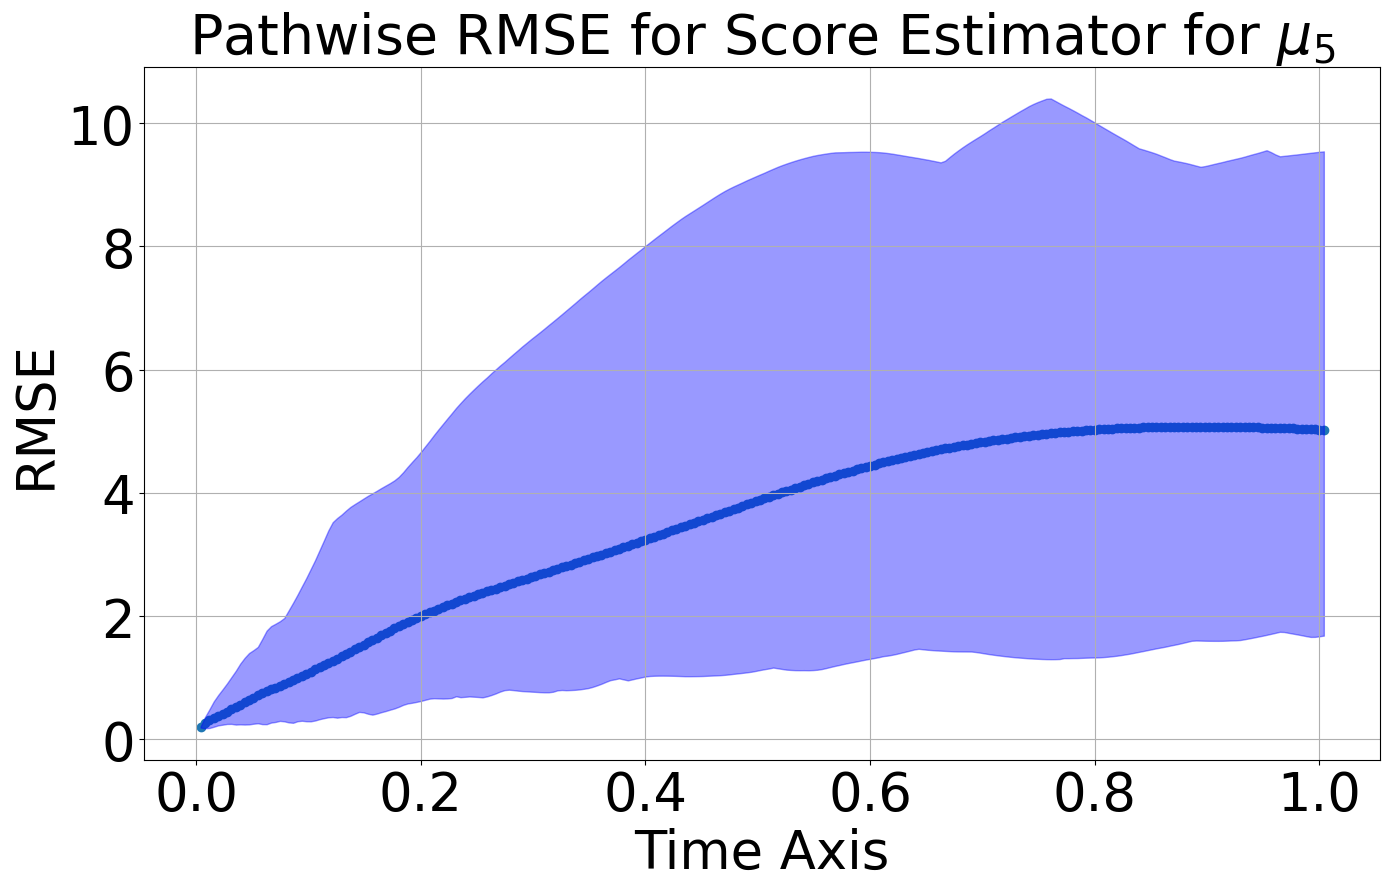

Final time cumulative MSE local-time error 5.0250172849862755 with final IQR (1.6820541449921318, 9.542882276180782) at Nepoch 76 for 0.75FConst



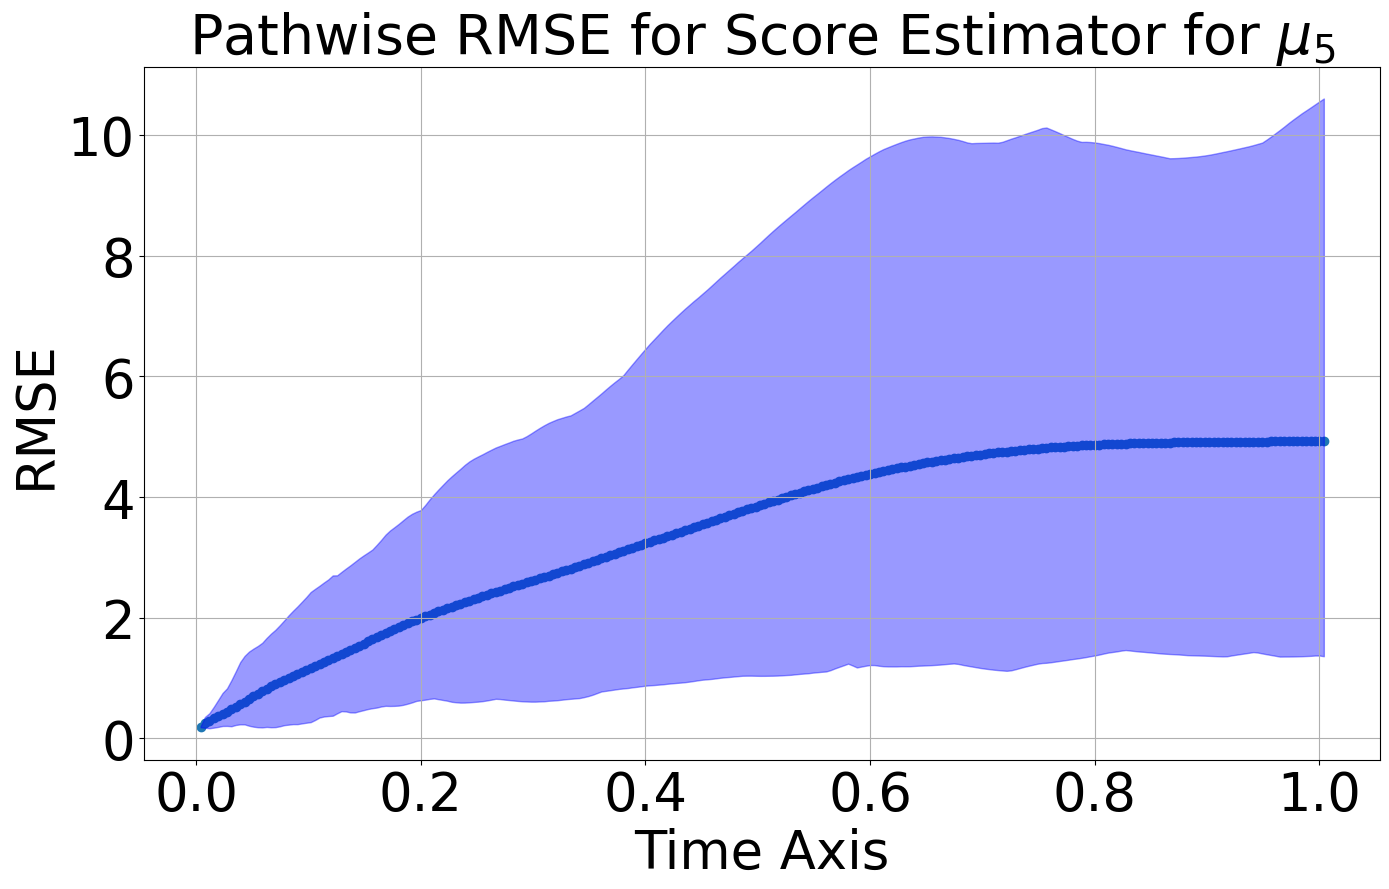

Final time cumulative MSE local-time error 4.924822123225536 with final IQR (1.362366125108303, 10.603873771153868) at Nepoch 102 for 0.75FConst



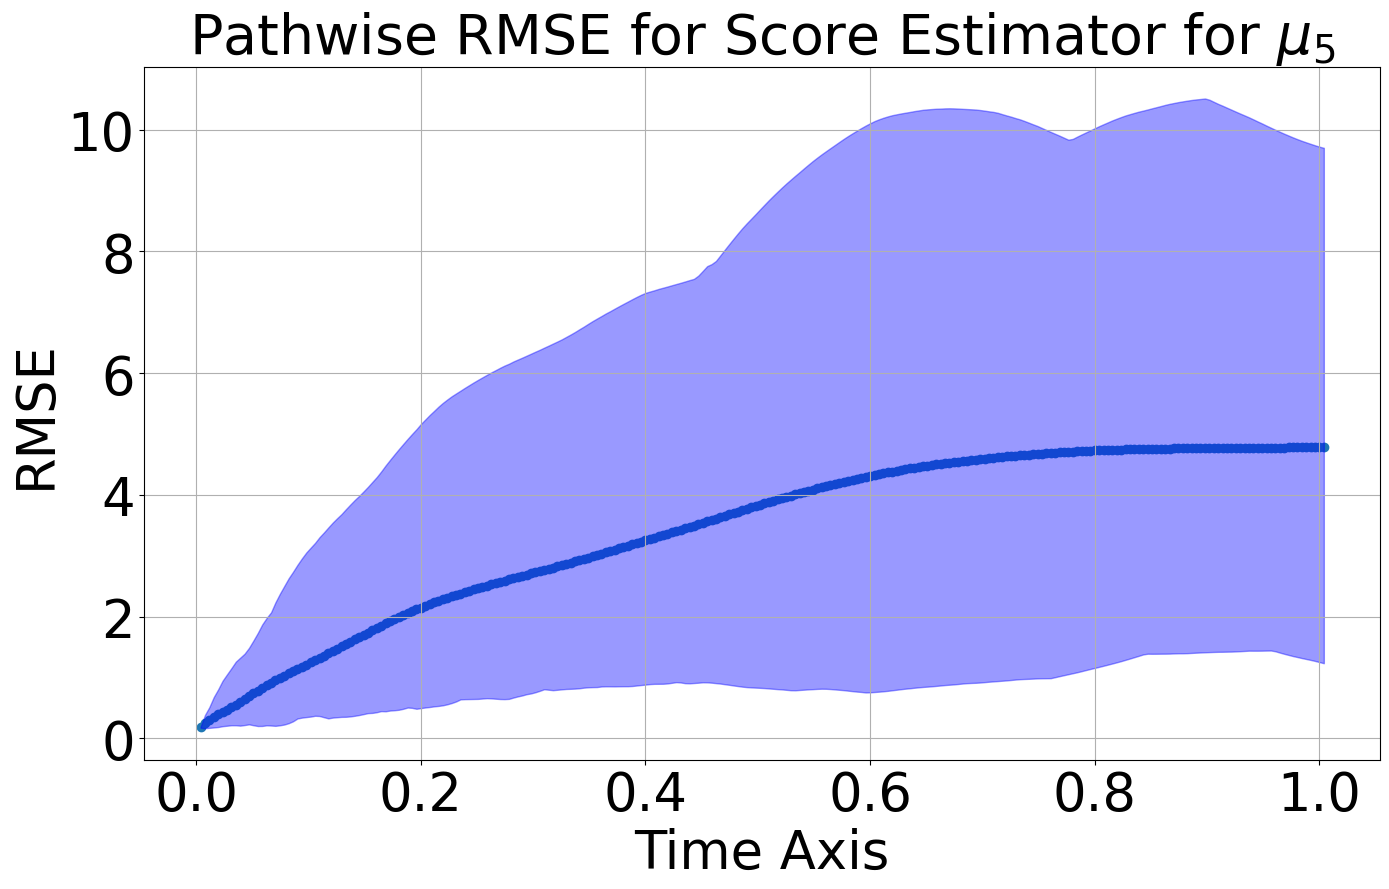

Final time cumulative MSE local-time error 4.783766146600509 with final IQR (1.233783369888072, 9.700883868744546) at Nepoch 142 for 0.75FConst



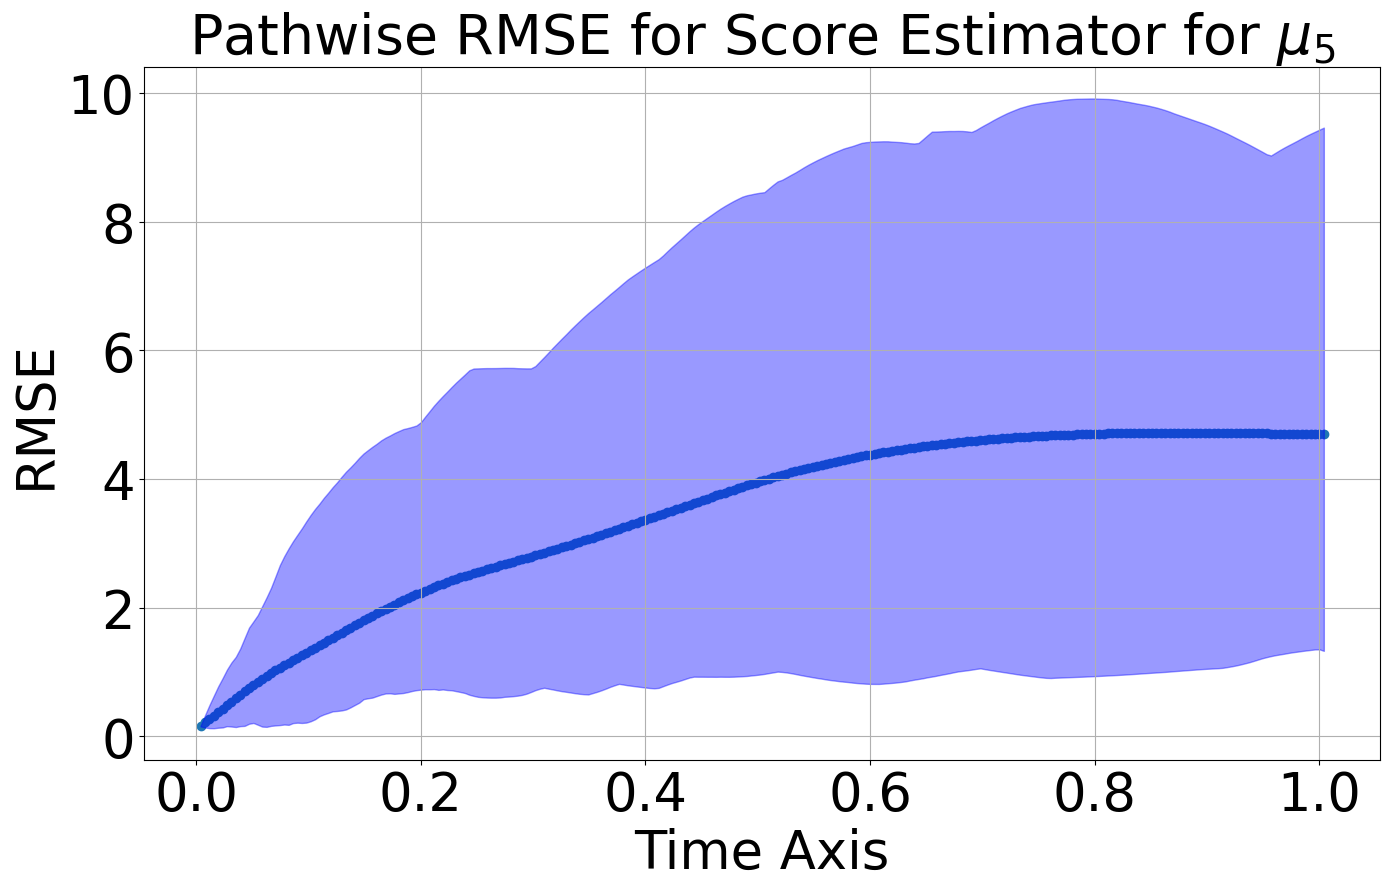

Final time cumulative MSE local-time error 4.691119763399544 with final IQR (1.3295575199122625, 9.45871219002734) at Nepoch 174 for 0.75FConst



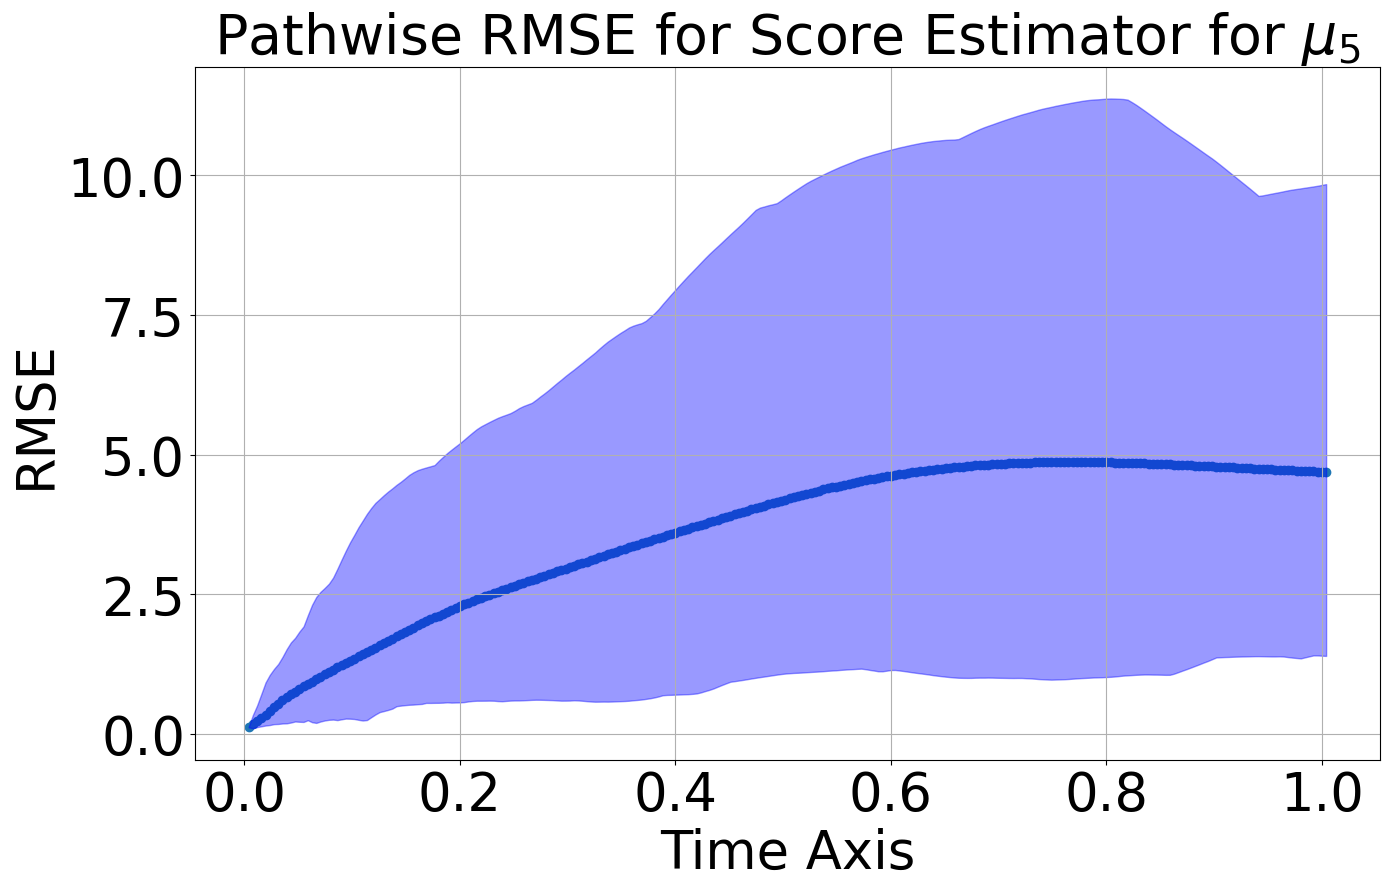

Final time cumulative MSE local-time error 4.688275469202287 with final IQR (1.3945034647839043, 9.844841014618885) at Nepoch 208 for 0.75FConst



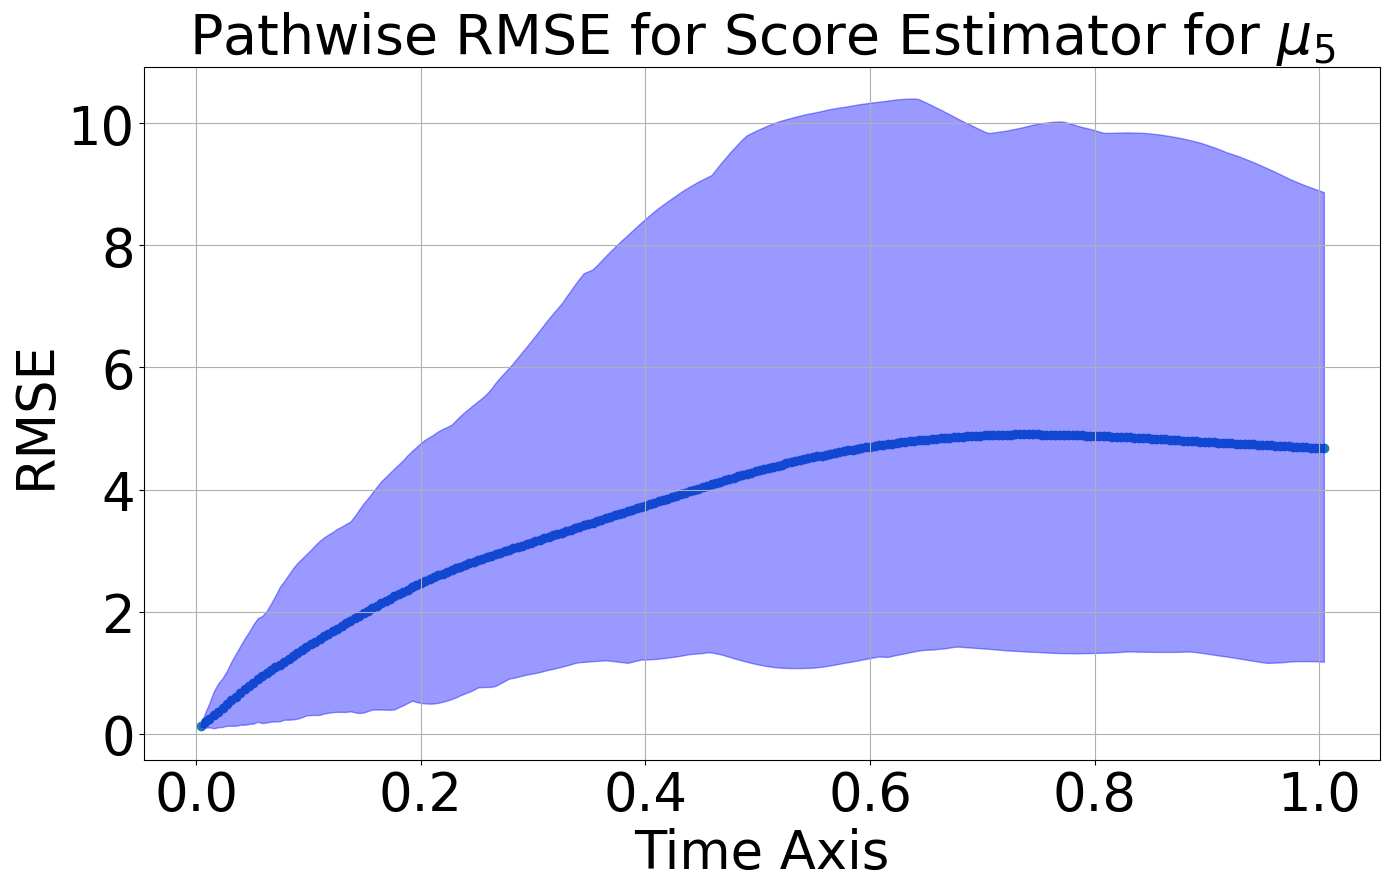

Final time cumulative MSE local-time error 4.674451428941034 with final IQR (1.1795478852821724, 8.873075053481205) at Nepoch 322 for 0.75FConst



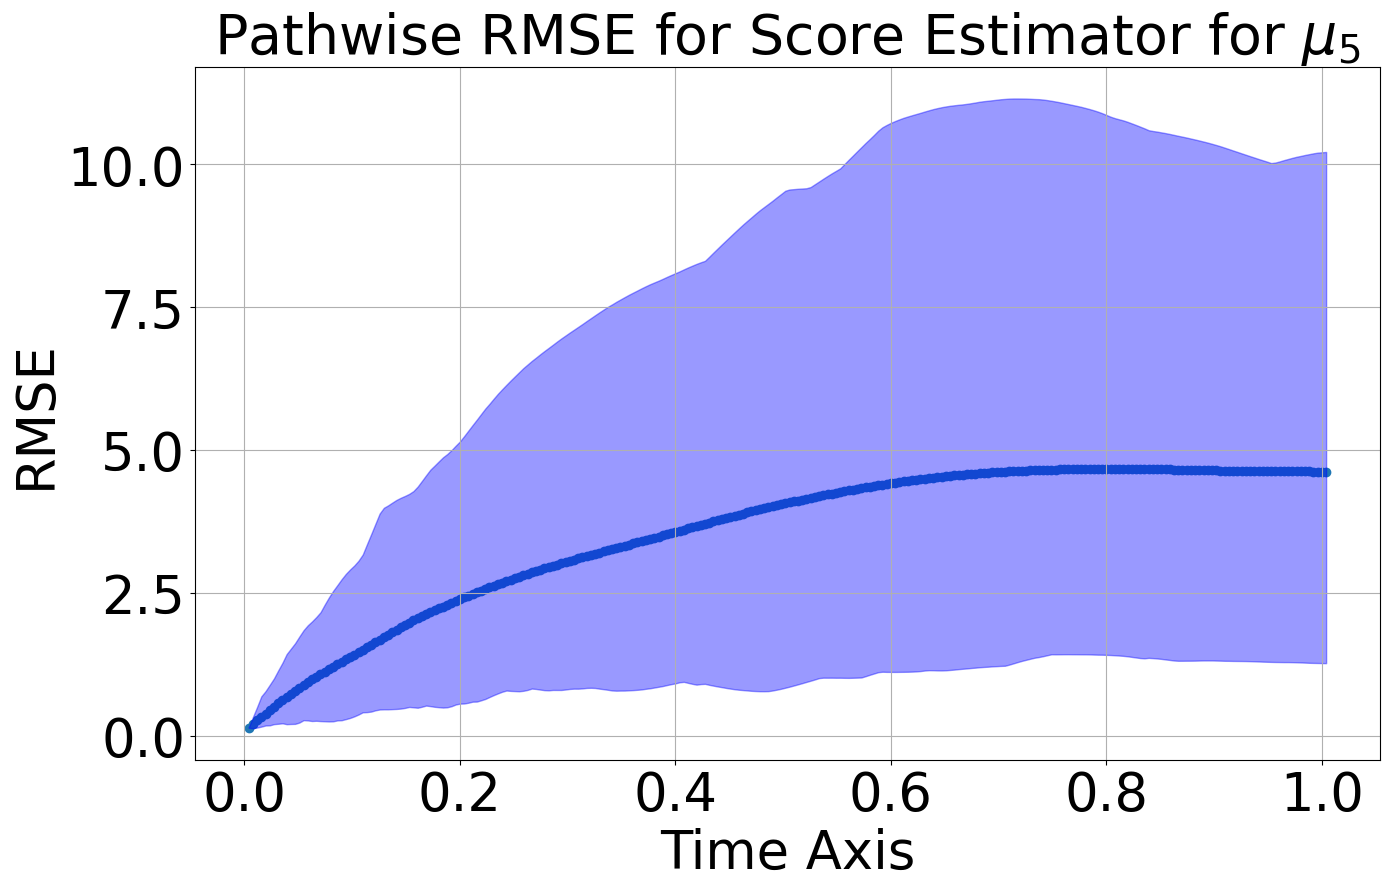

Final time cumulative MSE local-time error 4.620625386081231 with final IQR (1.2678899929841463, 10.212996030457118) at Nepoch 324 for 0.75FConst



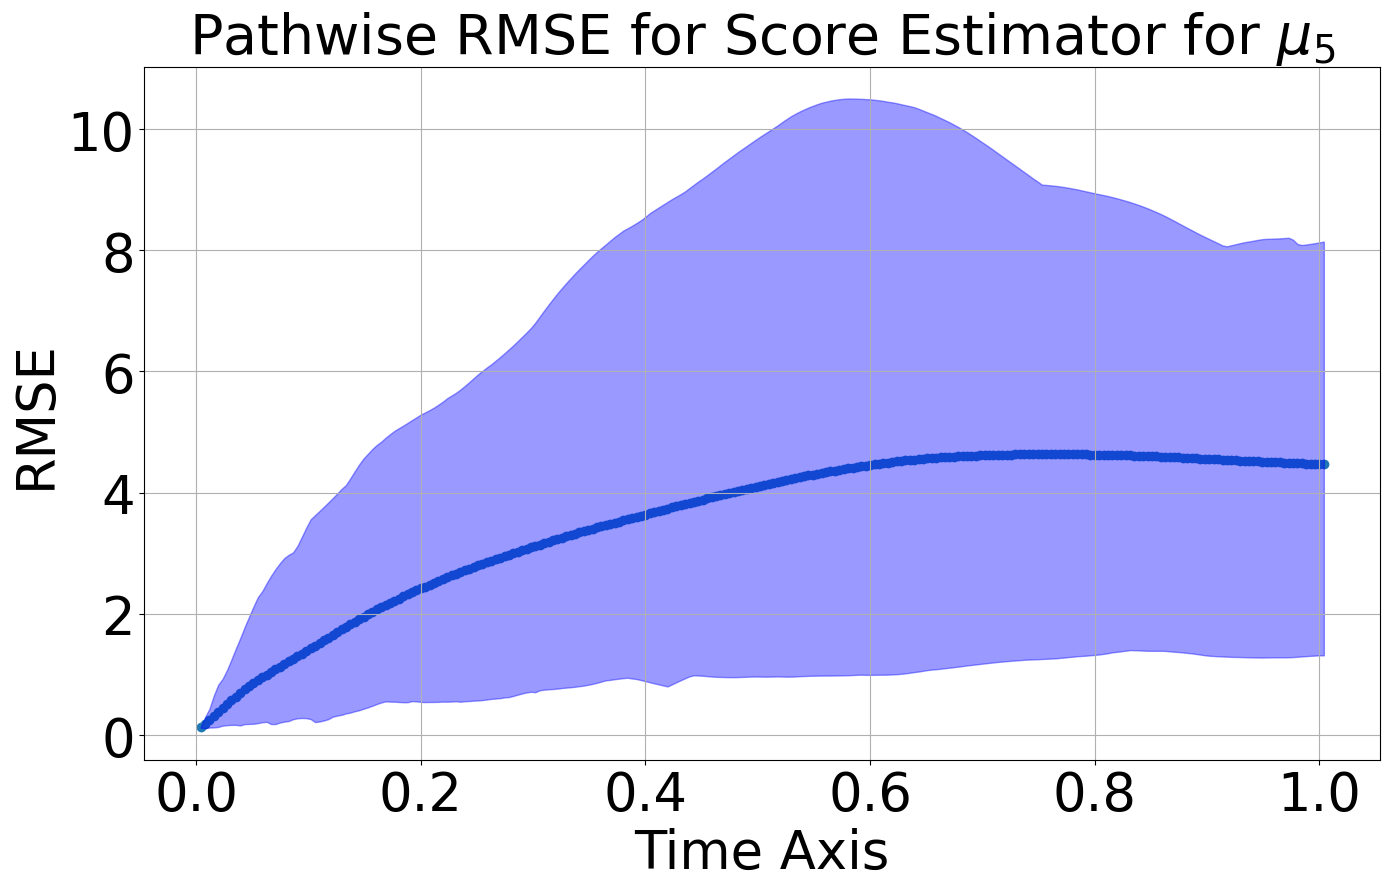

Final time cumulative MSE local-time error 4.471638498167206 with final IQR (1.3156153202832526, 8.141961769728779) at Nepoch 342 for 0.75FConst



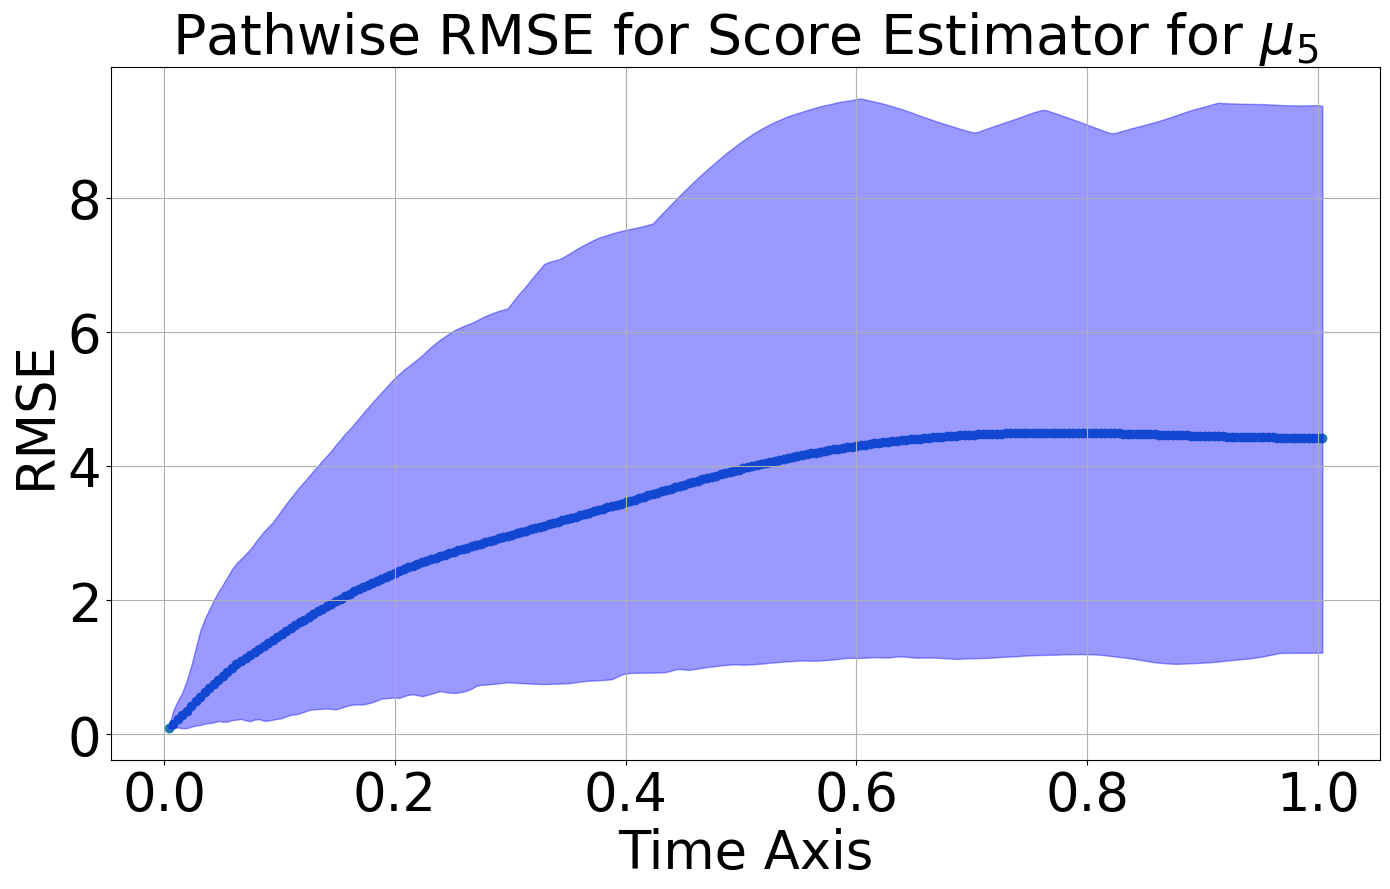

Final time cumulative MSE local-time error 4.412262889313636 with final IQR (1.2163520007536734, 9.368611083967643) at Nepoch 386 for 0.75FConst



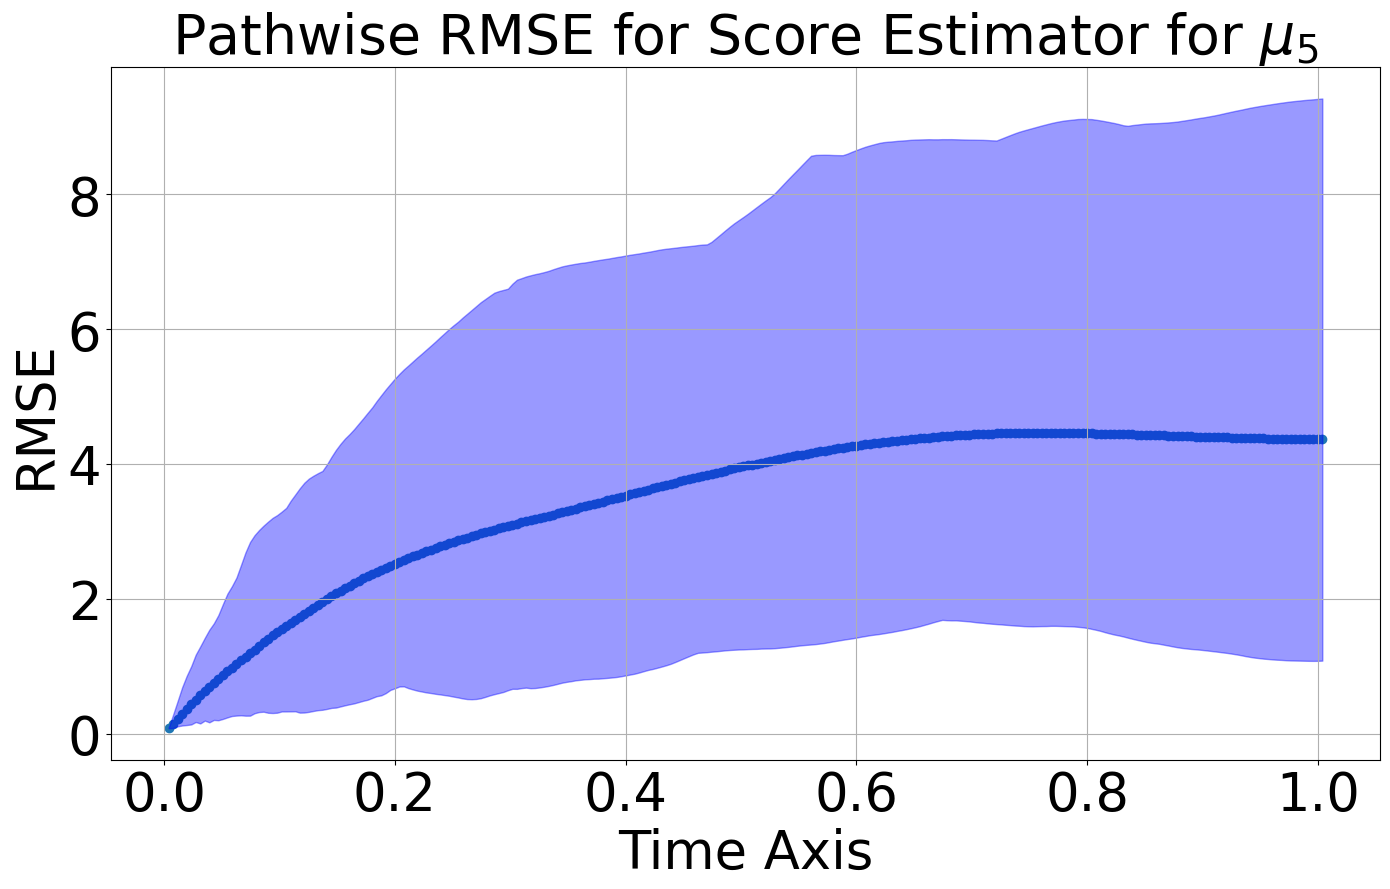

Final time cumulative MSE local-time error 4.371227364304663 with final IQR (1.0831762737515396, 9.421612318712182) at Nepoch 604 for 0.75FConst



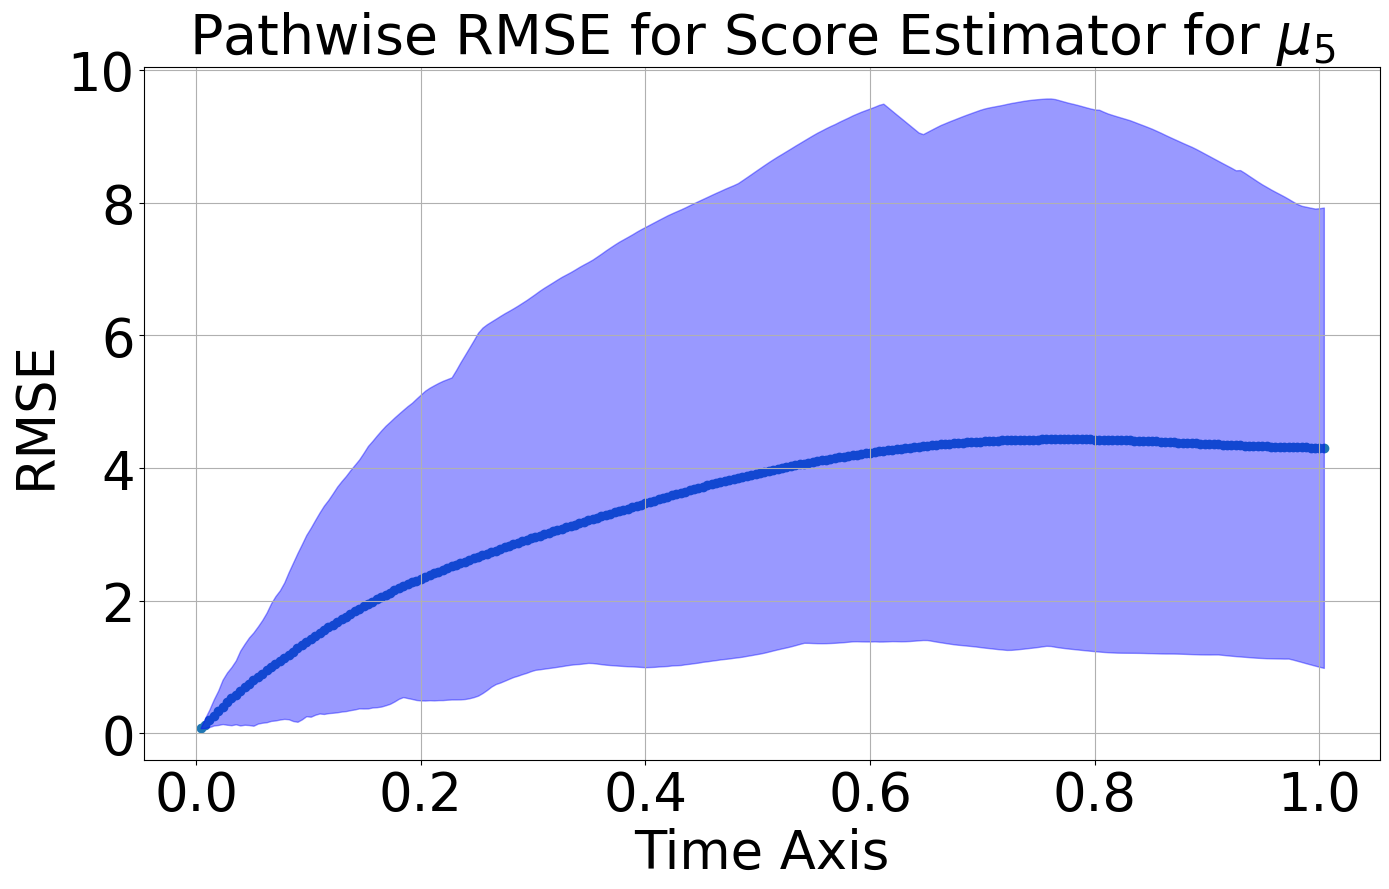

Final time cumulative MSE local-time error 4.305116425164462 with final IQR (0.9872901644095896, 7.926538869971822) at Nepoch 642 for 0.75FConst



In [13]:
curr_rmse = np.inf
toSave = False
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    ff_idx = np.argwhere(Nepoch == np.array(epochs_iter))[0,0]
    true = drift_true_files[ff_idx]
    local = drift_local_files[ff_idx]
    try:
        if Nepoch < 50: raise FileNotFoundError
        num_diff_times = 1
        all_true_states = np.load(true)
        all_local_states= np.load(local)
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Score Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/TSPM_Markovian/8DLnz/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_DriftTrack_{Nepoch}Nep_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue